# Ranking simulations based on quality evaluation based on order parameters

This notebook:

1. Ranks the individual simulations based on quality of order parameters of different fragments (headgroup, acyl chains and all order parameters)
2. Ranks simulations based on quality of invidual lipids

These rankings help to find the best simulations or force fields to analyze certain types of membranes or certain lipids.

# Initialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
#import mdtraj
import urllib.request
import yaml
import pprint
import pandas as pd
from pandas.io.json import json_normalize

sys.path.insert(1, '../BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def ShowTable(SortedQualities, quality):
    QualityTable = []
    for i in SortedQualities:
        StoredToTable = []
        StoredToTable = i[quality]
        StoredToTable['Forcefield'] = i['system']['FF']
        molecules = ''
        MolNumbers = ''
        for lipid in i['system']['COMPOSITION']:
            #print(np.sum(i['system']['COMPOSITION'][lipid]['COUNT']))
            molecules = molecules + lipid + ':'
            MolNumbers = MolNumbers + str(np.sum(i['system']['COMPOSITION'][lipid]['COUNT']))  + ':'
        StoredToTable['Molecules'] = molecules[:-1]
        StoredToTable['Number of molecules'] = ' (' + MolNumbers[:-1] + ')'
        StoredToTable['Temperature'] = i['system']['TEMPERATURE']
        StoredToTable['DOI'] = i['system']['DOI']
        QualityTable.append(StoredToTable)    
    display(pd.json_normalize(QualityTable))

# Making a list of qualities

In [2]:
qualities = []
for system in systems:
    quality_dict = {}
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    
    TotalQualityFilePath = path + '/SYSTEM_quality.json'
    
    
    
    FragmentQ = {}
    for lipid in readme['COMPOSITION']:
        QualityFile = path + lipid + '_FragmentQuality.json'
        #print(QualityFile)
        try:
            with open(QualityFile) as json_file:
                FragmentQ[lipid] = json.load(json_file)
            json_file.close()
        except:
            continue
        #print(lipid, FragmentQ[lipid])
    
    if (os.path.isfile(TotalQualityFilePath)):
        with open(TotalQualityFilePath) as json_file:
            FragmentQ['TotalQuality'] = json.load(json_file)
        json_file.close()
        #print(FragmentQ['TotalQuality'], '\n')
    
    FragmentQ['system'] = system
    qualities.append(FragmentQ)

# Sort based on total quality of a simulation

In [3]:
Fragments = ['total','sn-1','sn-2','headgroup']

for SortBasedOn in Fragments:
    #print(SortBasedOn)
    NewQualities = []
    for i in qualities:
        try:
            if i['TotalQuality'][SortBasedOn] >0:
                NewQualities.append(i)
            #totalQ = i['TotalQuality']['headgroup']
        except:
            continue

    
    SortedQualities = sorted(NewQualities, key = lambda i: i['TotalQuality'][SortBasedOn])
    print('Sorted based on ', SortBasedOn, ' quality')
    ShowTable(SortedQualities,'TotalQuality')
    
    outputfile = '../../Data/Ranking/SYSTEM_' + SortBasedOn + '_Ranking.json'
    with open(outputfile, "w") as fp:
        json.dump(SortedQualities, fp)
    

Sorted based on  total  quality


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
1,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
3,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
4,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415
5,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
6,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.00,10.5281/zenodo.1487906
7,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
8,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
9,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415


Sorted based on  sn-1  quality


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
1,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
3,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
4,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
5,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
6,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
7,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415
8,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.00,10.5281/zenodo.1487906
9,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415


Sorted based on  sn-2  quality


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
1,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
2,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
3,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129441
4,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.00,10.5281/zenodo.1487906
5,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
6,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
7,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415
8,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
9,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415


Sorted based on  headgroup  quality


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415
1,4.595849,0.000000,0.000000,0.000000,CHARMM36,POPG:SOL:SOD,(118:4110:118),298.00,10.5281/zenodo.1011096
2,5.689747,0.000000,0.000000,0.000000,CHARMM36,SOL:POPE,(5760:144),310.00,10.5281/zenodo.2641987
3,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129415
4,6.147453,0.000000,0.000000,0.000000,CHARMM36,SOL:POPE,(25000:500),310.00,10.5281/zenodo.3237461
5,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
6,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
7,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
8,24.731661,150.000000,150.000000,108.243887,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434
9,35.347785,0.000000,0.000000,0.000000,CHARMM36,POPG:POPC:SOL:SOD,(88:350:26280:88),298.00,10.5281/zenodo.3996952


# Sorting best simulations for each lipid

In [4]:
Fragments = ['total','sn-1','sn-2','headgroup']
#SortBasedOn = 'headgroup'

for SortBasedOn in Fragments:
    for lipid in lipids_dict:
        NewQualities = []
        for i in qualities:
            try:
                if i[lipid][SortBasedOn] >0:
                    NewQualities.append(i)
                #totalQ = i['TotalQuality']['headgroup']
            except:
                continue

    
        SortedQualities = sorted(NewQualities, key = lambda i: i[lipid][SortBasedOn])
        if SortedQualities:
            print('Quality of',SortBasedOn,' of ',lipid) #,'in simulation: ',  simulation[lipid][SortBasedOn])
            ShowTable(SortedQualities, lipid)
    
        if SortedQualities:
            outputfile = '../../Data/Ranking/' + lipid + '_' + SortBasedOn + '_Ranking.json'
            with open(outputfile, "w") as fp:
                json.dump(SortedQualities, fp)

    
        #for simulation in SortedQualities:
        #    for molecule in simulation['system']['COMPOSITION']:
        #        print(molecule, np.sum(simulation['system']['COMPOSITION'][molecule]['COUNT']))
        #    print(simulation['system']['FF'])
        #    print('Quality of',SortBasedOn,' of ',lipid,'in simulation: ',  simulation[lipid][SortBasedOn])
        #    print(simulation['system']['path'])
        #    print('\n')

Quality of total  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
1,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
3,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
4,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
5,49.463323,300.000000,300.000000,216.487774,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434


Quality of total  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
1,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
2,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
3,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
4,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
5,76.894742,178.918431,126.805673,127.539615,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425
6,77.219236,179.200169,141.855784,132.758396,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425


Quality of total  of  CHOL


,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,207.259677,slipids,CHOL:POPC:SOL,(256:256:20334),298.0,10.5281/zenodo.159434


Quality of sn-1  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
1,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
3,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
4,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
5,49.463323,300.000000,300.000000,216.487774,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434


Quality of sn-1  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
1,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
2,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
3,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
4,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
5,76.894742,178.918431,126.805673,127.539615,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425
6,77.219236,179.200169,141.855784,132.758396,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425


Quality of sn-2  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
1,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
2,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
3,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
4,22.051387,2.336907,49.327075,24.571790,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
5,49.463323,300.000000,300.000000,216.487774,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434


Quality of sn-2  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
1,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
2,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
3,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
4,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
5,76.894742,178.918431,126.805673,127.539615,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425
6,77.219236,179.200169,141.855784,132.758396,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425


Quality of headgroup  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,7.546477,19.308345,17.561283,14.805369,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
1,8.887443,nan,nan,nan,CHARMM36,POPG:POPC:SOL:SOD,(88:350:26280:88),298.00,10.5281/zenodo.3996952
2,15.924261,30.097444,19.568097,21.863267,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
3,22.051387,2.336907,49.327075,24.57179,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
4,49.463323,300.0,300.0,216.487774,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434
5,62.126873,0.535656,1.682661,21.448397,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
6,82.268459,nan,nan,nan,lipid17ecc,POPG:POPC:SOL:SOD,(88:350:26265:88),298.00,10.5281/zenodo.3997154
7,87.469465,nan,nan,nan,Slipids,POPC:POPG:SOD:SOL,(128:128:128:12800),298.00,10.5281/zenodo.3613573
8,105.170638,0.356573,1.741698,35.756303,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
9,170.089083,nan,nan,nan,lipid17ecc,POPG:POPC:SOL:SOD,(150:150:29865:150),298.00,10.5281/zenodo.3859339


Quality of headgroup  of  POPG


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,4.595849,nan,nan,nan,CHARMM36,POPG:SOL:SOD,(118:4110:118),298.0,10.5281/zenodo.1011096
1,114.045799,nan,nan,nan,Slipids,POPG:SOL:SOD,(288:10664:288),298.0,10.5281/zenodo.546133


Quality of headgroup  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
1,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
2,76.894742,178.918431,126.805673,127.539615,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425
3,77.219236,179.200169,141.855784,132.758396,Berger,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129425
4,92.816126,40.559991,16.474276,49.950131,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
5,170.675169,4.764065,7.588560,61.009265,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
6,171.442649,8.981030,8.384775,62.936151,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441


Quality of headgroup  of  POPE


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,5.689747,nan,nan,nan,CHARMM36,SOL:POPE,(5760:144),310.0,10.5281/zenodo.2641987
1,6.147453,nan,nan,nan,CHARMM36,SOL:POPE,(25000:500),310.0,10.5281/zenodo.3237461
2,184.082922,nan,nan,nan,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
3,187.350685,nan,nan,nan,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813


# Making very rough plots on quality

This is not very user friendly. Can be probably removed once the GUI works.

/tmp/ipykernel_4960/208112679.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(5,value[5],"s",color='red',label = l,marker=".", markersize=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels f

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

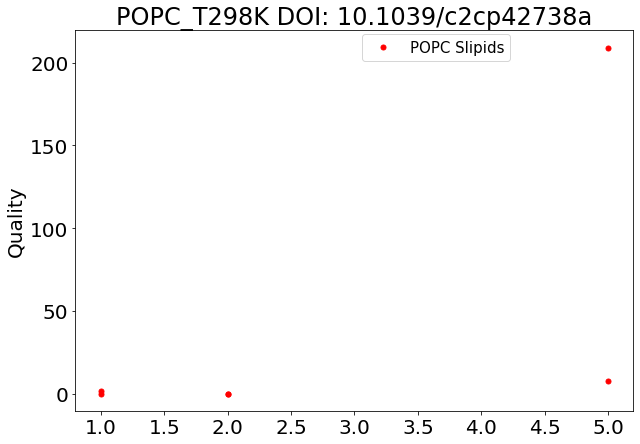

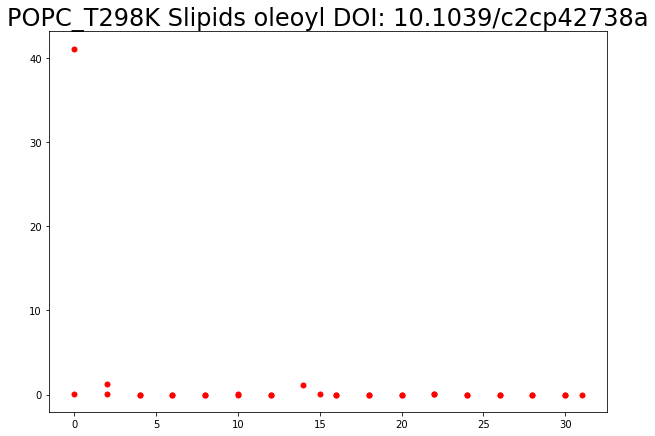

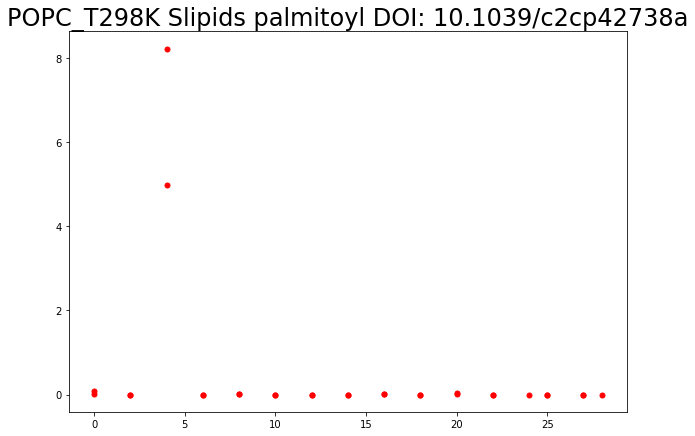

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

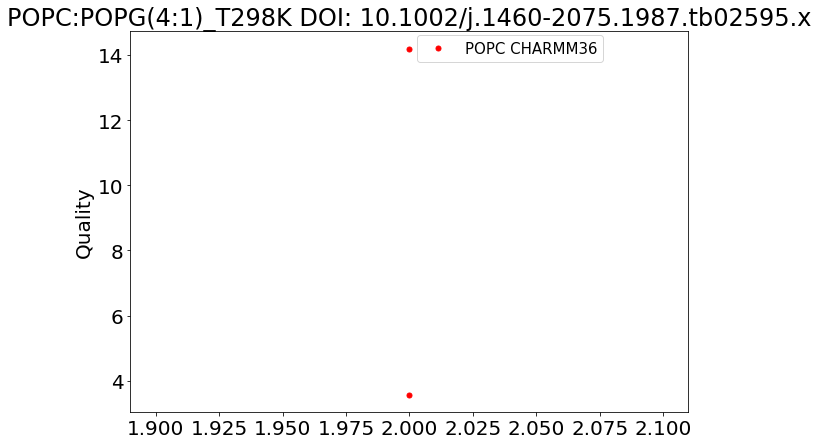

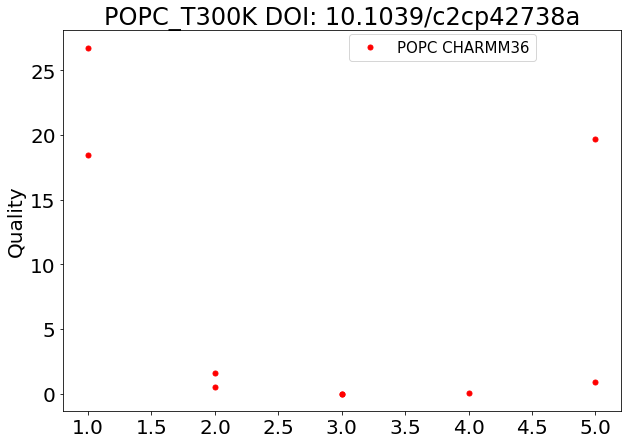

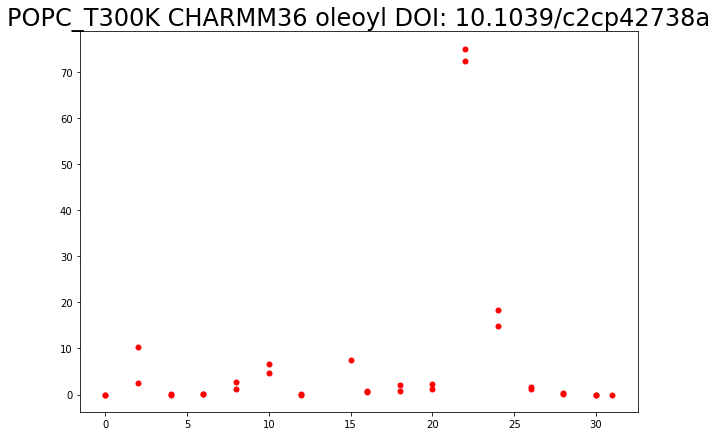

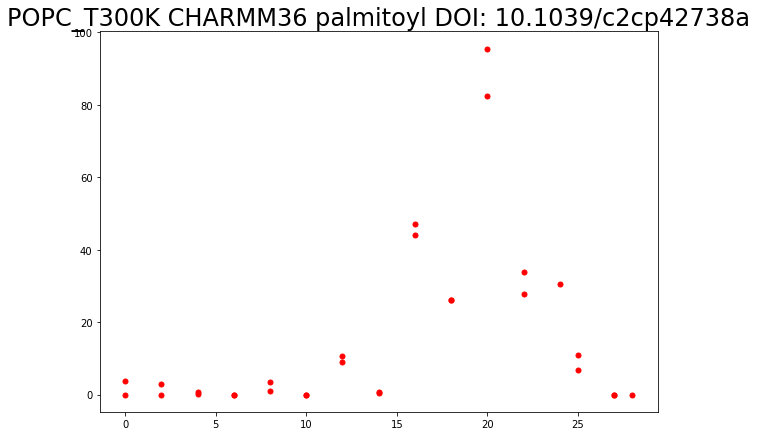

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

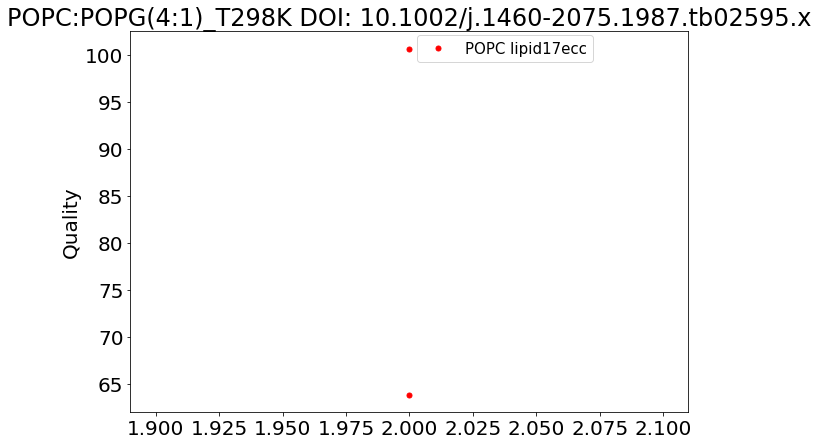

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

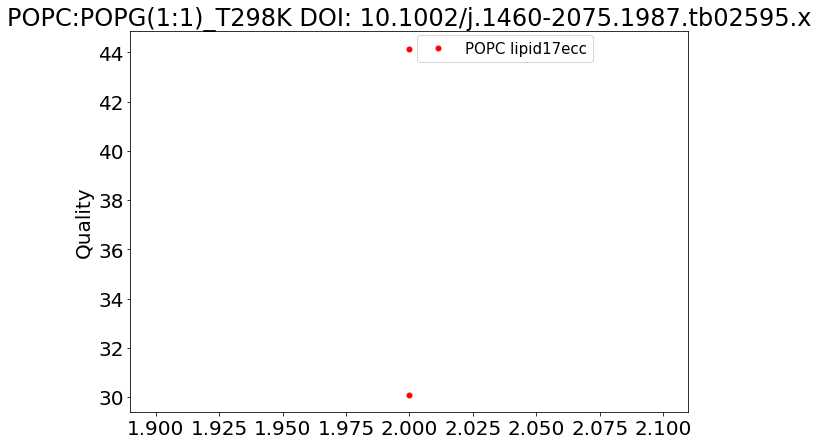

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

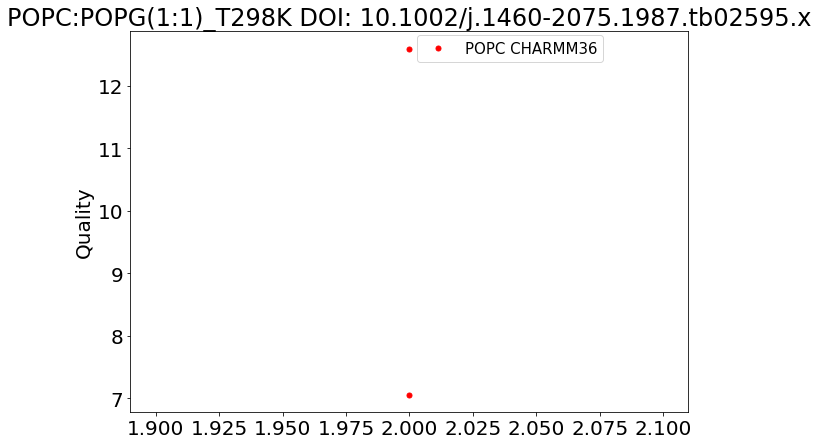

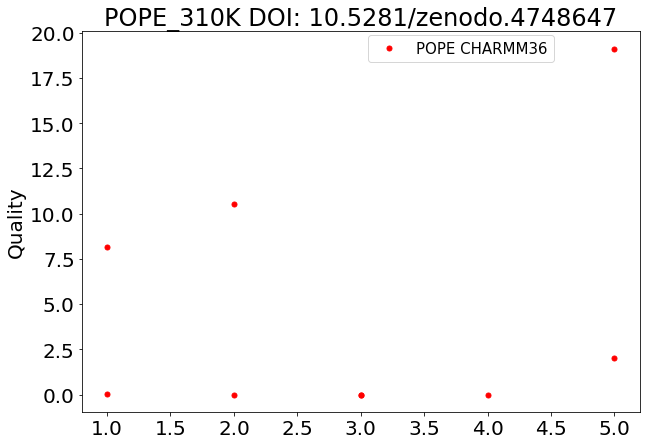

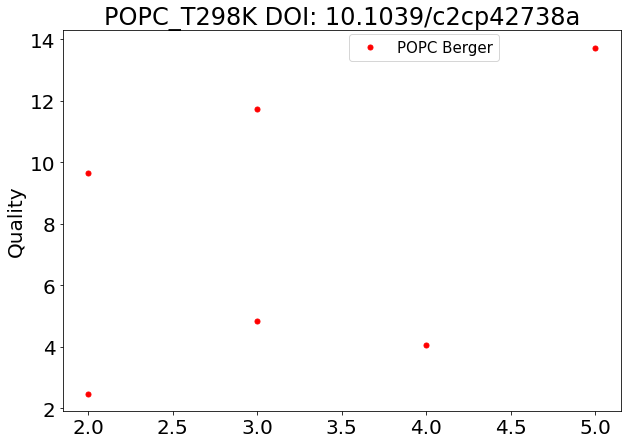

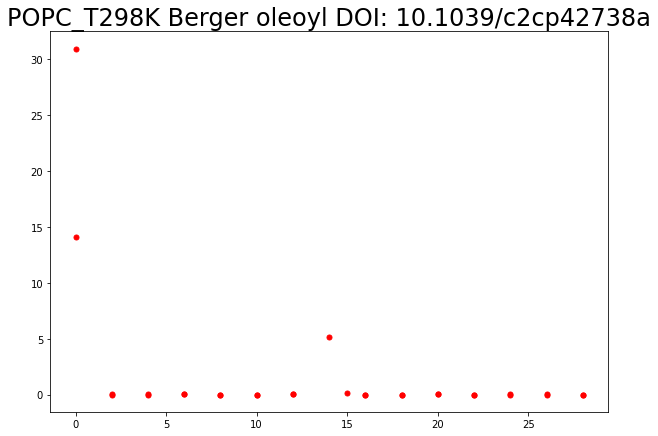

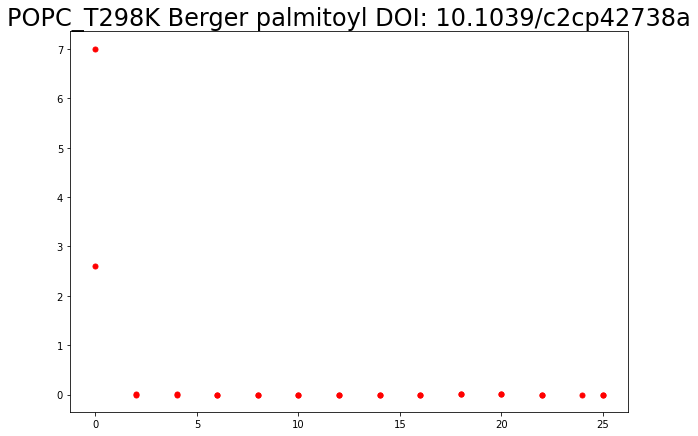

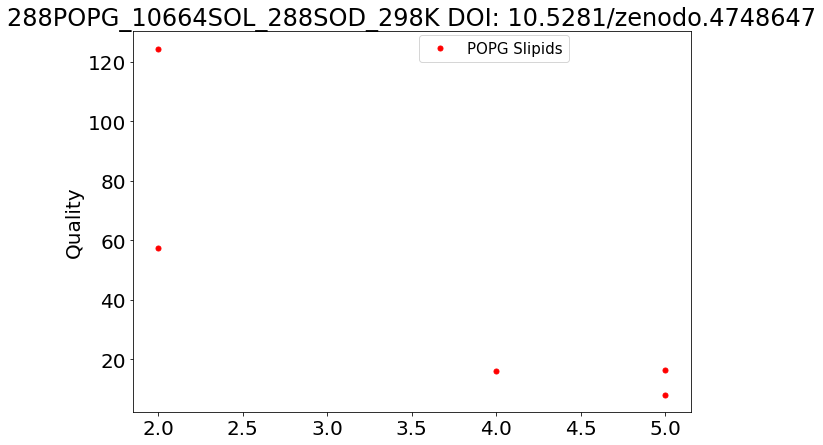

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

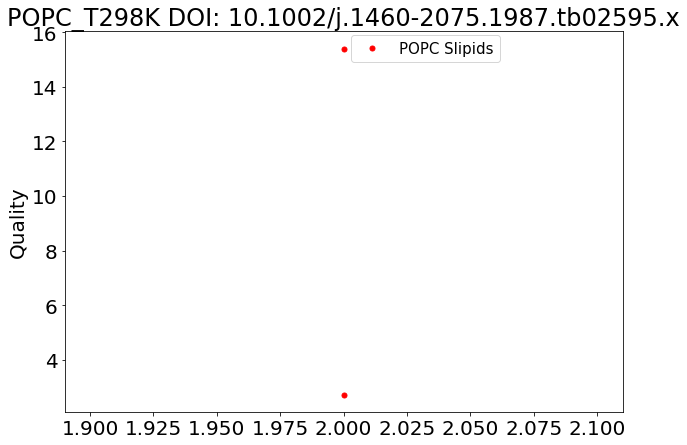

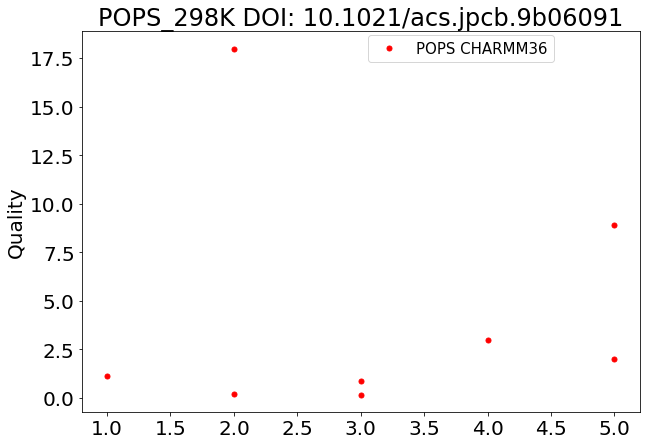

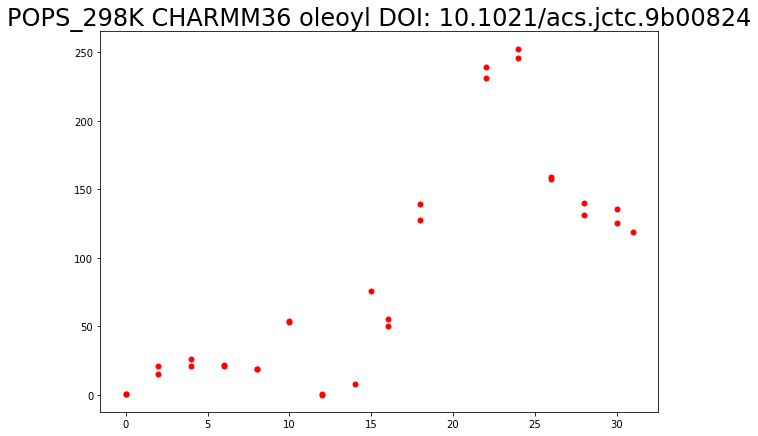

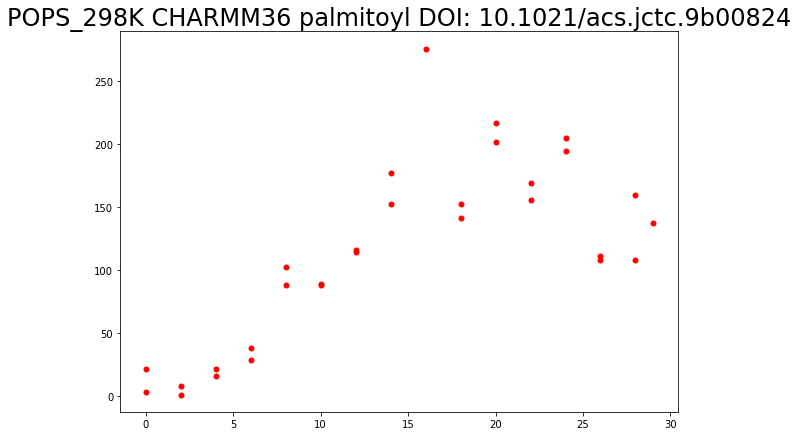

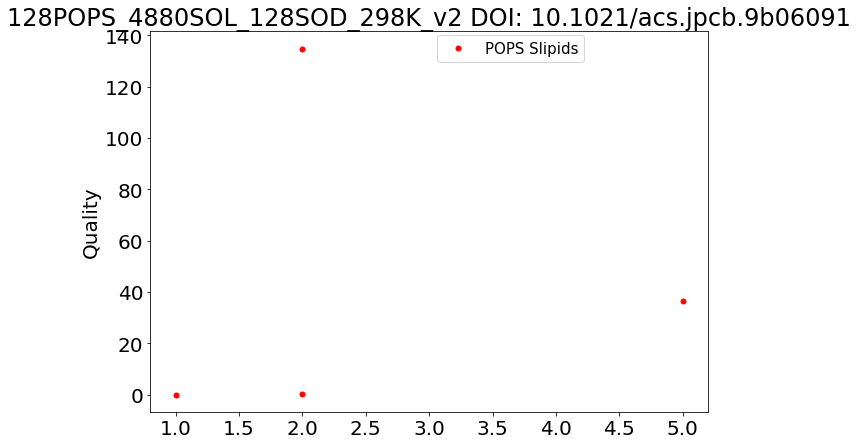

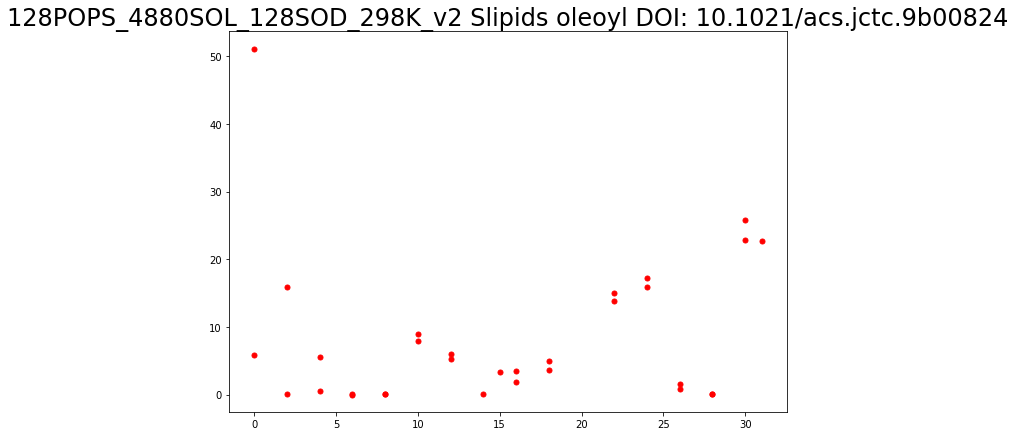

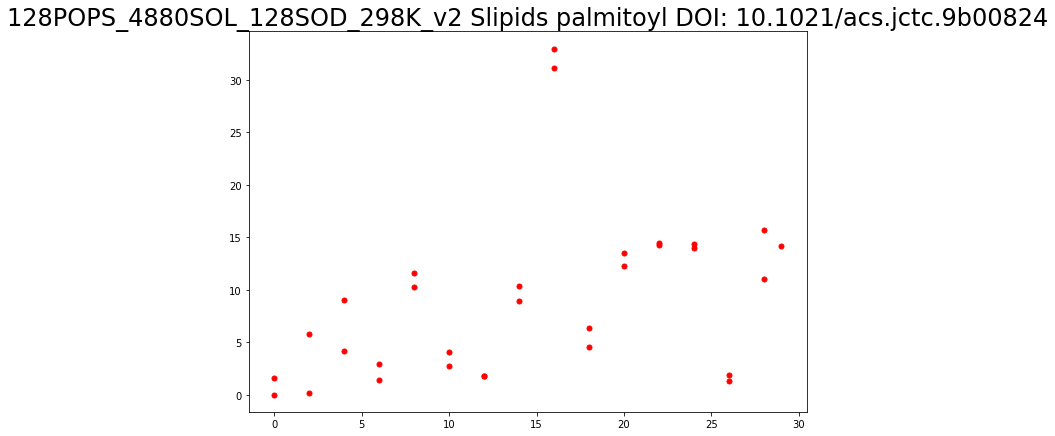

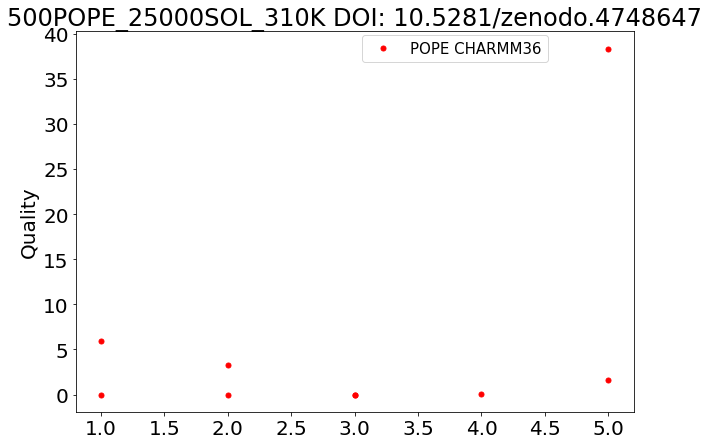

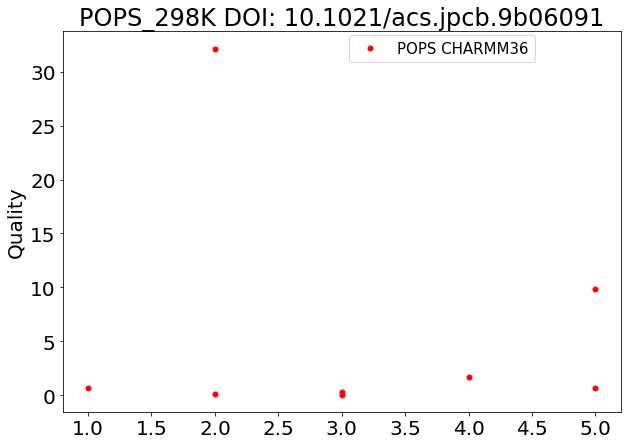

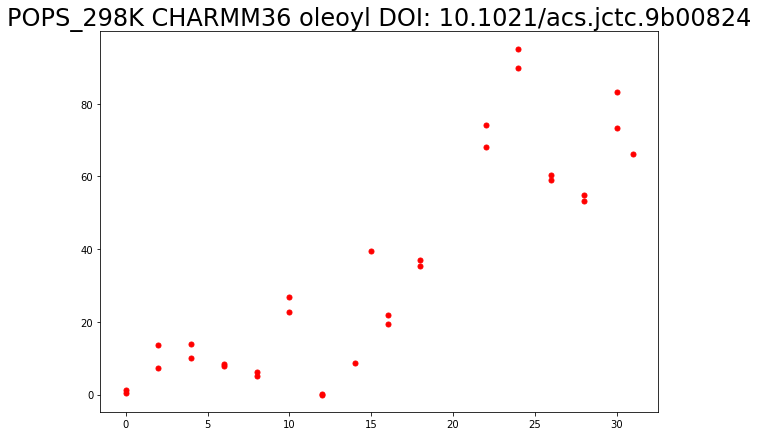

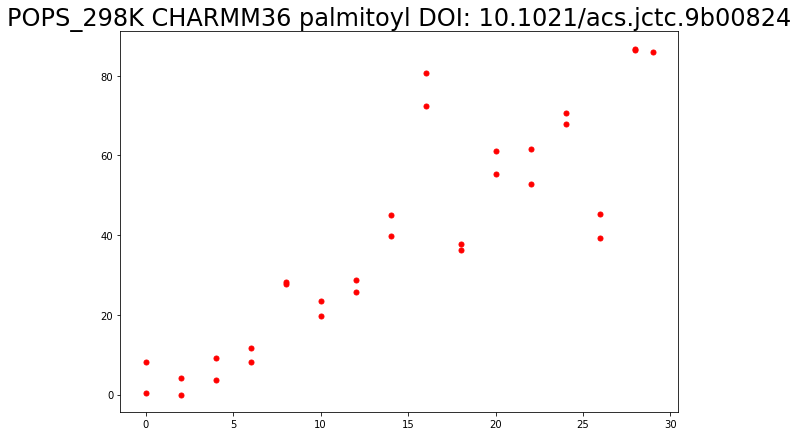

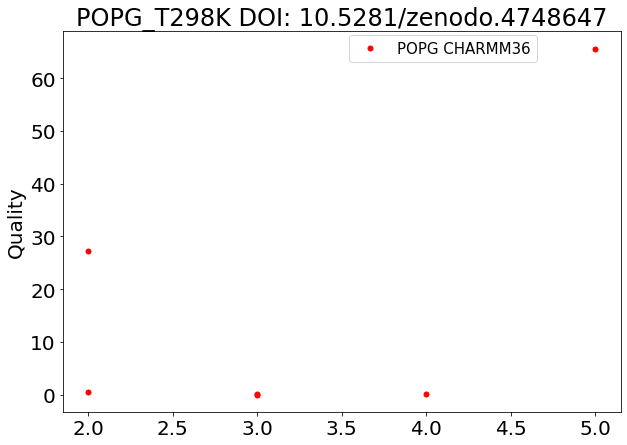

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

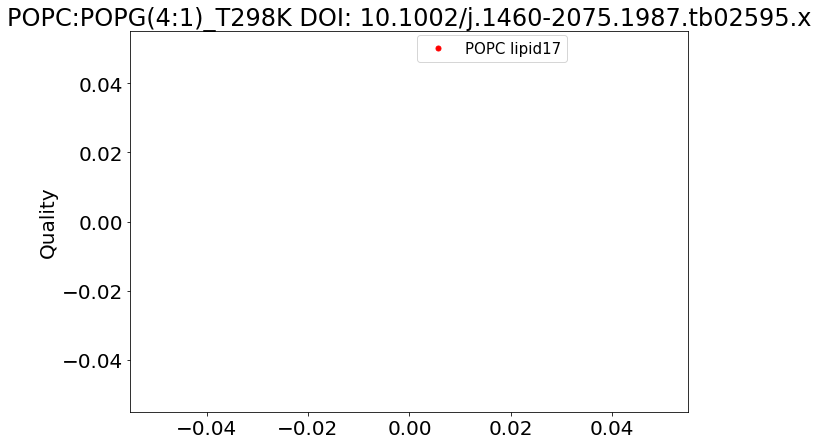

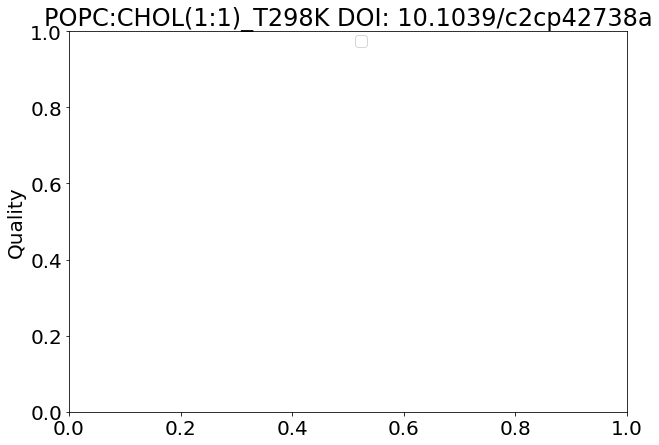

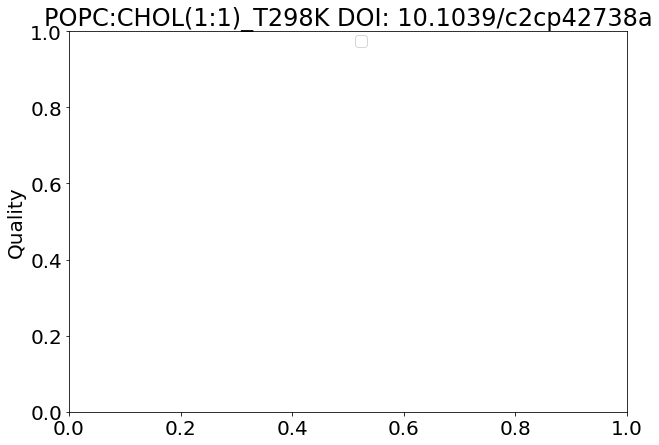

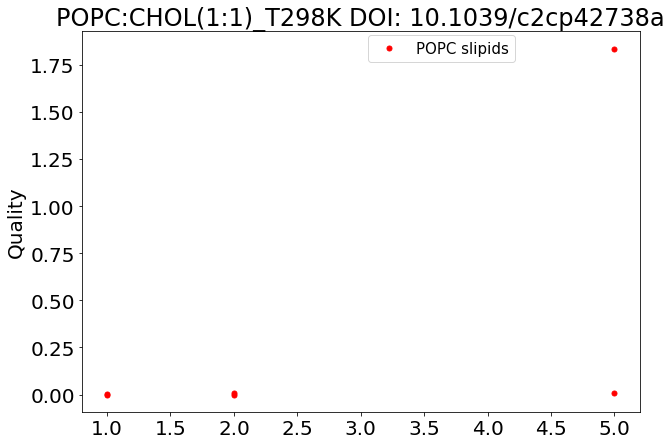

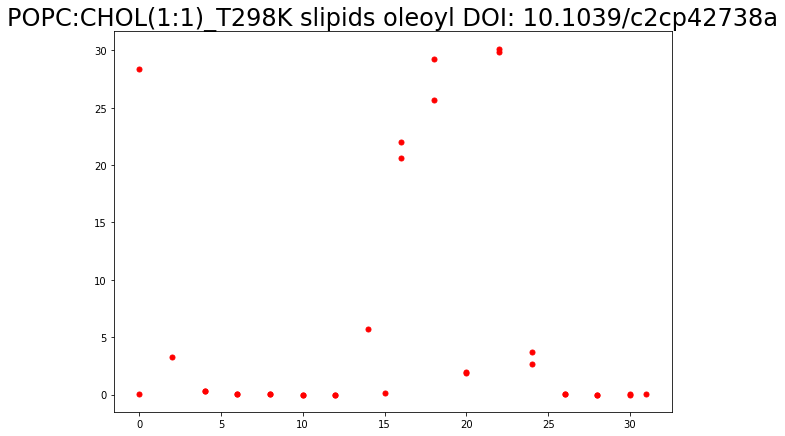

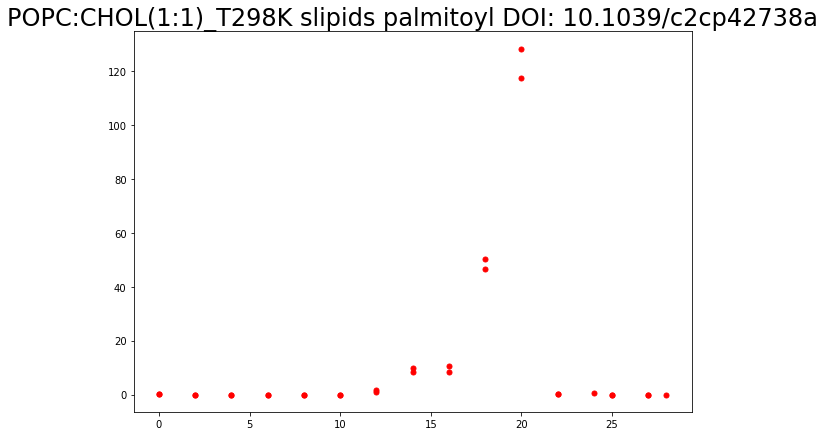

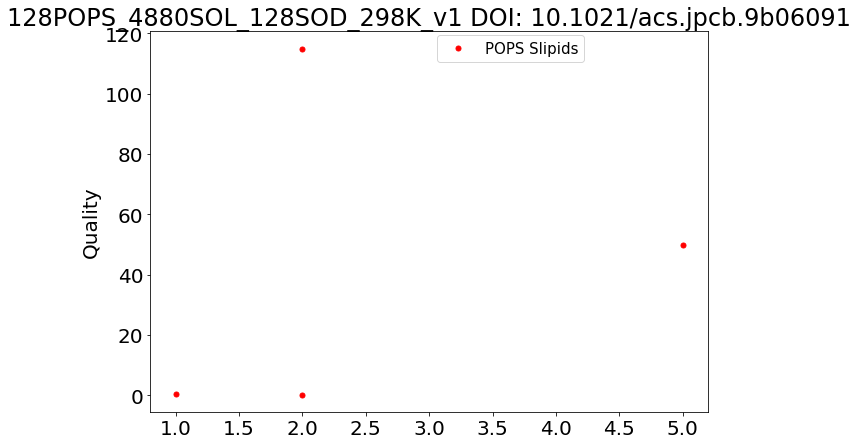

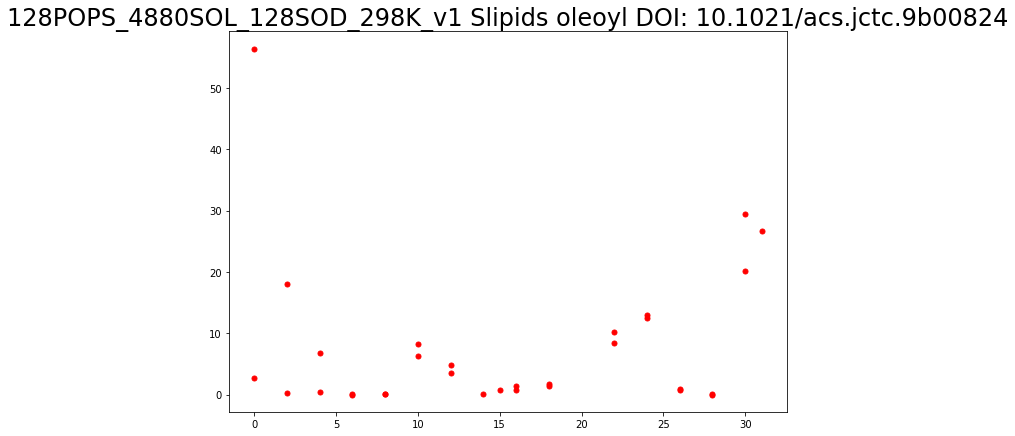

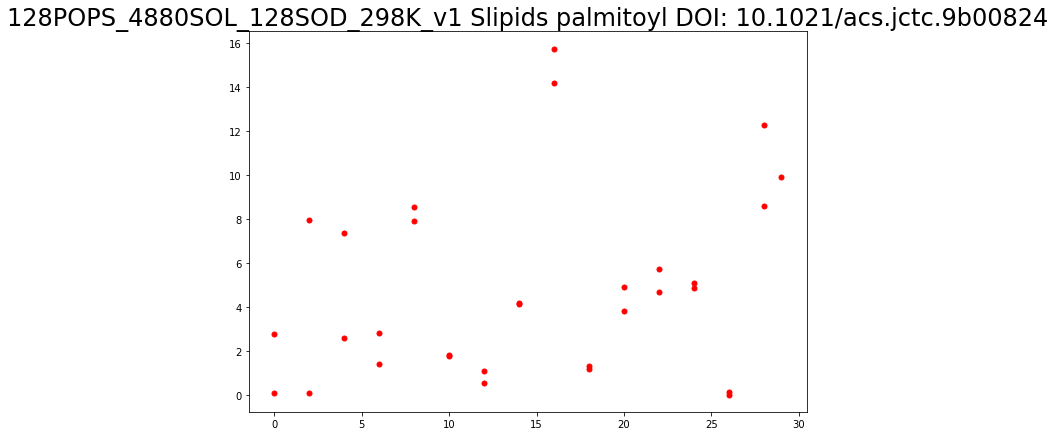

In [6]:
    
def plotHeadGroup(readme, data, lipid):
    fig= plt.figure(figsize=(10,7))
    #print(data)
    for doi in data:
        RealData = data[doi]
        for key2, value in RealData.items():
            #print(key2,value)                    
            #plt.gca().invert_yaxis()
            #plt.ylim([0,1])               
            if lipid == 'POPG' and 'M_G3C6_M' in key2:
                l = None
                plt.plot(0,value[5],"s", color='red', label = l,marker=".", markersize=10)  #color=colors[i],
            if 'M_G3N6' in value: 
                l = None
                plt.plot(0,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C5_M' in key2:
                l = None
                plt.plot(1,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C4_M' in key2:
                l = None
                plt.plot(2,value[5],"s",color='red', label = l,marker=".", markersize=10)
            if 'M_G3_M' in key2:
                l = None
                plt.plot(3,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G2_M' in key2:
                l = lipid + " " + readme.get('FF')
                plt.plot(4,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G1_M' in key2:
                l = None
                plt.plot(5,value[5],"s",color='red',label = l,marker=".", markersize=10)
            plt.legend( loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            plt.ylabel('Quality', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            # plt.ylim(0,-1050)
            plt.title(readme['SYSTEM'] + " DOI: " + doi, fontsize=24)

    return fig



def plotTails(readme,data,name_tail):
    for doi in data:
        RealData = data[doi]
        keys_list = list(RealData.keys())
        tail = []
        if name_tail == 'palmitoyl':
            tail = [x for x in keys_list if 'M_G1C' in x]
        elif name_tail == 'oleoyl':
            tail = [x for x in keys_list if 'M_G2C' in x]
        
        if tail:
            fig1= plt.figure(figsize=(10,7))
            previous_key = ""
            for index, key in enumerate(tail):
                #plt.gca().invert_yaxis()
                #plt.ylim([0,1])
                if key[0:-3] == previous_key[0:-3]:
                    plt.plot(index-1,RealData[key][5],"s",color='red',marker=".", markersize=10)
                else:
                    plt.plot(index,RealData[key][5],"s",color='red',marker=".", markersize=10)
                if key[0:-3] != previous_key[0:-3]:
                    previous_key = key
            plt.title(readme['SYSTEM'] + " " + readme['FF'] + " " + name_tail + " DOI: " + doi, fontsize=24)
            # plt.legend(loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            # plt.ylabel('Quality', fontsize=20)
            return fig1
        else:
            print('No quality data for acyl tails')
            return ""

for system in systems:
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    for files in os.walk(path):
        #for file in files[2]:
        #    print(file)
        OPdata = {}
        for filename2 in files[2]:
            filepath2 = path + filename2
            if filepath2.endswith("_OrderParameters_quality.json"):
                lipid = filename2.replace('_OrderParameters_quality.json', '')
                #print(filepath2)
                with open(filepath2) as json_file:
                    OPdata[lipid] = json.load(json_file)
                json_file.close()
                #print(OPdata)
            
                #plot head group
                for key1 in OPdata.keys():
                    #print(key1)
                    data = OPdata[key1]
                    doi = readme['DOI']
                    #print(data)
                    plotHeadGroup(readme, data, key1) 
                    # plot oleoyl
                    name_tail = ["oleoyl","palmitoyl"]
                    plotTails(readme,data, name_tail[0])
                # plot palmitoyl
                    plotTails(readme,data, name_tail[1])
            